<a href="https://colab.research.google.com/github/cs20m016/cs6910-Assignment-2/blob/main/PartA%5B4_5%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#!unzip /content/gdrive/MyDrive/nature_12K.zip

In [34]:
!unzip /content/gdrive/MyDrive/nature_12K.zip > /dev/null

replace inaturalist_12K/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [67]:
import keras
import tensorflow as tf
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os, random
import matplotlib.gridspec as gridspec
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model



In [36]:
batch_size = 32
img_height = 180
img_width = 180
data_dir='/content/inaturalist_12K/train'

In [62]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9999 files belonging to 10 classes.
Using 9000 files for training.


In [38]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9999 files belonging to 10 classes.
Using 999 files for validation.


In [39]:
class_names = train_ds.class_names
print(class_names)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


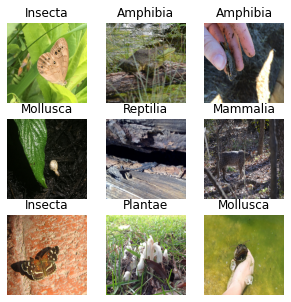

In [40]:
#first 9 images in training dataset
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [41]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

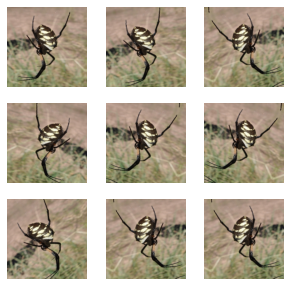

In [42]:
plt.figure(figsize=(5, 5))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [75]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [44]:
ag_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [45]:
AUTOTUNE = tf.data.AUTOTUNE

ag_train_ds = ag_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [76]:
test_dir='/content/inaturalist_12K/val'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=1,
    shuffle='False')

Found 2000 files belonging to 10 classes.


In [ ]:
def plot_train(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(history.history['loss']))

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  return

In [ ]:
def best_model():
  num_classes = 10
  filter_no = [32,64,128,256,512]
  kernel_size = [4,4,4,4,4]
  act_function = ['relu','relu','relu','relu','relu']
  dense_act='relu'
  dense_neurons = 256
  epoch=10
  lr=0.001
  optimizer =tf.keras.optimizers.Adam(lr=lr)
  early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, min_delta=0.001, mode='max')
  model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(filter_no[0], kernel_size[0], activation=act_function[0]),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(0.1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filter_no[1], kernel_size[1], activation=act_function[1]),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(0.1),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filter_no[2], kernel_size[2], activation=act_function[2]),
    layers.BatchNormalization(),
    #layers.SpatialDropout2D(0.3),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filter_no[3], kernel_size[3], activation=act_function[3]),
    layers.BatchNormalization(),
    #layers.SpatialDropout2D(0.3),
    layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    layers.Conv2D(filter_no[4], kernel_size[4], activation=act_function[4]),
    layers.BatchNormalization(),
    #layers.SpatialDropout2D(0.3),
    layers.MaxPooling2D(pool_size=(2, 2),strides=2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(dense_neurons, activation=dense_act,kernel_initializer='GlorotUniform'),
    layers.Dense(num_classes,activation='softmax')
  ])
  model.compile(optimizer=optimizer,loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
  history = model.fit(ag_train_ds,validation_data=valid_ds,epochs=epoch,callbacks=[early_stopping])
  plot_train(history)
  model.evaluate(test_ds,batch_size=1)
  return model

In [ ]:
def predict():
  plt.figure(figsize=(25, 25))
  id=0
  for subdir in os.listdir(test_dir):
    files=[random.choice(os.listdir(os.path.join(test_dir, subdir))) for i in range(3)]
    index=1
    for file in files:
      path=os.path.join(os.path.join(test_dir, subdir),file)
      #print(path)
      img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))
      img_array = keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) # Create a batch

      predictions = model.predict(img_array)
      score = tf.nn.softmax(predictions[0])

      plt.subplot(10,10,id*10+index)
      plt.imshow(img)
      plt.title("{},{:.2f}".format(class_names[np.argmax(score)], 100 * np.max(score)))
      plt.axis("off")
      index+=1
    id+=1
  return

In [ ]:
model = best_model()

In [ ]:
model.summary()

In [ ]:
predict(model)

In [58]:
#Convolutional layers of model
for layer in model.layers:
	if 'conv' not in layer.name:
		continue
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_15 (4, 4, 3, 32)
conv2d_16 (4, 4, 32, 64)
conv2d_17 (4, 4, 64, 128)
conv2d_18 (4, 4, 128, 256)
conv2d_19 (4, 4, 256, 512)


**Random image selected for visualisation of filters**

In [222]:
rn_class = random.choice(os.listdir(data_dir))
rn_file = random.choice(os.listdir(os.path.join(data_dir, rn_class)))
rn_path = os.path.join(os.path.join(data_dir, rn_class),rn_file)
print(rn_path)

/content/inaturalist_12K/train/Amphibia/8b64ecb9f0cc0a174ab51a1e29146d4d.jpg


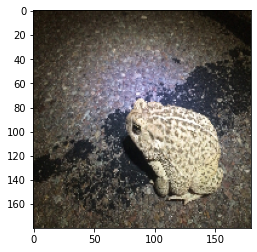

In [223]:
rn_image = keras.preprocessing.image.load_img(rn_path, target_size=(img_height, img_width))
plt.imshow(rn_image)

In [224]:
filters,biases=model.layers[1].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
filter_count=filters.shape[3]
no_of_filter=8
depth=filters.shape[2]
print(filter_count,depth)

32 3


**First few layer 1 convolutional filters (RGB channels along column)**

In [225]:
lg=int(math.log(filter_count,2))
row =int(math.pow(2,int(lg/2)))
col =int(math.pow(2,lg-int(lg/2)))

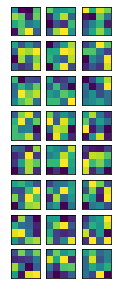

In [226]:
ind=0
plt.figure(figsize=(5, 5))
for id in range(no_of_filter):
  filt=filters[:,:,:,id]
  for i in range(depth):
    ax=plt.subplot(no_of_filter,no_of_filter,no_of_filter*ind+i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(filt[:,:,i])
  ind+=1
plt.show()

In [227]:
img = keras.preprocessing.image.load_img(rn_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
visual_model=Model(inputs=model.input,outputs=model.layers[1].output)
visual_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3_input (InputLaye [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 177, 177, 32)      1568      
Total params: 1,568
Trainable params: 1,568
Non-trainable params: 0
_________________________________________________________________


**Visualiation of all filters in the first layer of Model**

In [228]:
feature_map=visual_model.predict(img_array)
print(feature_map.shape)

(1, 177, 177, 32)


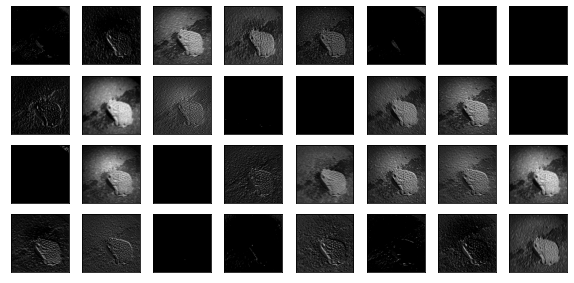

In [229]:
index=1
plt.figure(figsize=(10, 10))
for i in range(row):
  for j in range(col):
    ax=plt.subplot(col,col,i*col+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_map[0,:,:,index-1],cmap='gray')
    index+=1
plt.show()

**Visualisation of Guided Back Propogation on 10 neurons in the last Convolutional Layer**

In [230]:
IMAGE_PATH = '/content/inaturalist_12K/train/Plantae/c0b25c821f91a66dc20c33af504fcf65.jpg'
LAYER_NAME='conv2d_19'

In [231]:
IMG = keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(img_height, img_width))
IMG_array = keras.preprocessing.image.img_to_array(IMG)
IMG_array = tf.expand_dims(IMG_array, 0)

In [232]:
gb_model = tf.keras.models.Model(inputs = [model.inputs],    
    outputs = [model.get_layer(LAYER_NAME).output])
oshape = model.get_layer(LAYER_NAME).output.shape[1:]
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

In [233]:
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

In [234]:
def guided_gb_plot(preprocessed_input,xindex,yindex,zindex):
  with tf.GradientTape() as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)[0][xindex][yindex][zindex]
  grads = tape.gradient(outputs,inputs)[0]
  guided_back_prop =grads
  gb_viz = np.dstack((
              guided_back_prop[:, :, 0],
              guided_back_prop[:, :, 1],
              guided_back_prop[:, :, 2],
          ))       
  gb_viz -= np.min(gb_viz)
  gb_viz /= gb_viz.max()
  return gb_viz

In [235]:
for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu

In [236]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

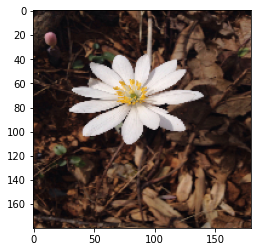

In [237]:
plt.imshow(IMG)

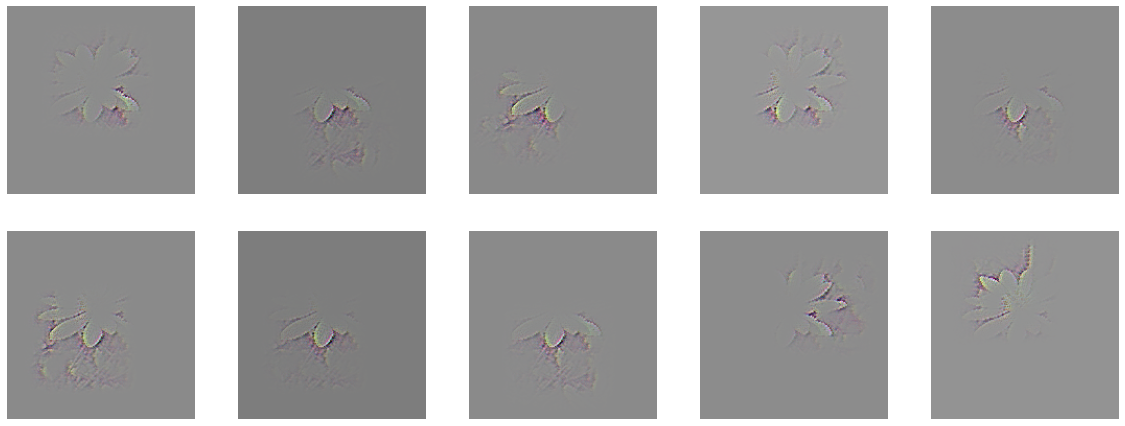

In [262]:
plt.figure(figsize=(20, 20))
ar=[(1,2,316),(4,3,305),(3,0,68),(1,3,481),(3,2,110),(3,1,70),(3,1,375),(4,2,219),(1,4,459),(0,1,14)]
for i in range(10):
  #xindex=random.randint(0,oshape[0]-1)
  #yindex=random.randint(0,oshape[1]-1)
  #zindex=random.randint(0,oshape[2]-1)
  (xindex,yindex,zindex)=ar[i]
  gb_v = guided_gb_plot(IMG_array,xindex,yindex,zindex)
  ax=plt.subplot(5,5,i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(gb_v)
  plt.axis("off")
plt.show()

**Visualisation of Grad-CAM**

In [197]:
import cv2
import tensorflow.keras.backend as K
from skimage.transform import resize
%matplotlib inline

In [218]:
def grad_CAM(preprocessed_input,img):
  with tf.GradientTape() as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)[0]
  grads = tape.gradient(outputs,inputs)[0]
  weights = tf.reduce_mean(grads, axis=(0, 1))
  grad_cam = np.ones(outputs.shape[0: 2], dtype = np.float32)
  for i, w in enumerate(weights):
      grad_cam += w * outputs[:, :, i]
  grad_cam_img = cv2.resize(grad_cam.numpy(), (180, 180))
  grad_cam_img = np.maximum(grad_cam_img, 0)
  heatmap = (grad_cam_img - grad_cam_img.min()) / (grad_cam_img.max() - grad_cam_img.min())
  grad_cam_img = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.8, grad_cam_img, 1, 0)
  return output_image

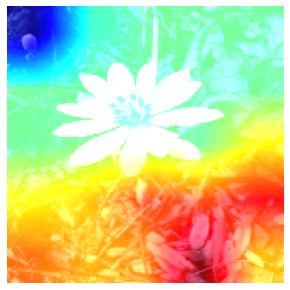

In [255]:
plt.figure(figsize=(60, 60))
file_path ='/content/inaturalist_12K/train/Plantae/c0b25c821f91a66dc20c33af504fcf65.jpg'
ig = keras.preprocessing.image.load_img(file_path, target_size=(img_height, img_width))
ig_array = keras.preprocessing.image.img_to_array(ig)
preprocessed = tf.expand_dims(ig_array, 0)
out_cam = grad_CAM(preprocessed,ig_array)
ax=plt.subplot(10,10,i+1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(out_cam)
plt.axis("off")
plt.show()

**Guided Grad CAM Visualisation**

In [253]:
def guided_grad_CAM(preprocessed_input):
  with tf.GradientTape() as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)[0]
  grads = tape.gradient(outputs,inputs)[0]
  guided_back_prop=grads
  weights = tf.reduce_mean(grads, axis=(0, 1))
  grad_cam = np.ones(outputs.shape[0: 2], dtype = np.float32)
  for i, w in enumerate(weights):
      grad_cam += w * outputs[:, :, i]
  guided_cam = np.maximum(grad_cam, 0)
  guided_cam = guided_cam / np.max(guided_cam) # scale 0 to 1.0
  guided_cam = resize(guided_cam, (180,180), preserve_range=True)
  gd_gb = np.dstack((
        guided_back_prop[:, :, 0] * guided_cam,
        guided_back_prop[:, :, 1] * guided_cam,
        guided_back_prop[:, :, 2] * guided_cam,
    ))
  return gd_gb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


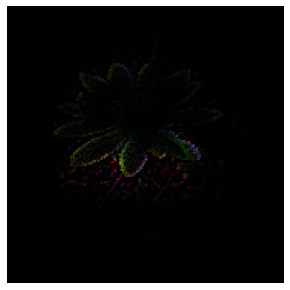

In [254]:
plt.figure(figsize=(60, 60))
file_path = '/content/inaturalist_12K/train/Plantae/c0b25c821f91a66dc20c33af504fcf65.jpg'
ig = keras.preprocessing.image.load_img(file_path, target_size=(img_height, img_width))
ig_array = keras.preprocessing.image.img_to_array(ig)
preprocessed = tf.expand_dims(ig_array, 0)
out_cam = guided_grad_CAM(preprocessed)
ax=plt.subplot(10,10,i+1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(out_cam)
plt.axis("off")
plt.show()